# CNN -- LeNet-5 implementation from scratch

This is an implementation of LeNet-5 from Yann LeCun's paper (http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf) in 1998.

Without using any deep learning frameworks, accuracy of 95.6% on the MNIST test dataset has been achieved after just 4 epoches of traininig. Implementation is done from scratch, largely using Numpy.

In [1]:
import os
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from sklearn.model_selection import train_test_split
from keras.datasets import mnist

Using TensorFlow backend.


## 1. Data Import & Preprocessing

### 1.1 Data Import

LeNet-5 was designed for classifying hand writing digits. MNIST is a dataset of handwritten digits, which can be imported directly from Keras or downloaded from Yann LeCun's website.

In [2]:
(x_train_raw, y_train_raw), (x_test_raw, y_test_raw) = mnist.load_data()

print("y_train.shape",y_train_raw.shape)
print("x_train.shape",x_train_raw.shape)
print("x_test.shape",x_test_raw.shape)
print("y_test.shape",x_test_raw.shape)

y_train.shape (60000,)
x_train.shape (60000, 28, 28)
x_test.shape (10000, 28, 28)
y_test.shape (10000, 28, 28)


In [3]:
print("size of a single image:   ", x_train_raw[1].shape)
print("number of output classes: ", len(np.unique(y_train_raw)))

size of a single image:    (28, 28)
number of output classes:  10


### 1.2 Data Visualisation

In [4]:
def displayData(x, nrow=5, ncol=5):
    """
    Displays a random set of input images
    """
    m,n = x.shape[0], x.shape[1]* x.shape[2]
    
    #select a random sample
    x = x[np.random.randint(m, size = nrow * ncol)]
            
    fig = plt.figure(figsize = (5,5))
    gs = gridspec.GridSpec(nrow, ncol)
    
    k = 0
    
    for i in range(nrow):
        for j in range(ncol):
            ax = plt.subplot(gs[i,j])
            ax.axis('off')
            ax.imshow(x[k], cmap = 'Greys')
            
            k += 1

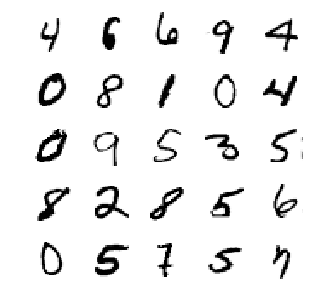

In [5]:
displayData(x_train_raw, 5, 5)

### 1.3 Data Preprocessing

Before feeding the images into the ConvNet, the input is reshaped, zero-padded with pad = 2, and normalized. The normalization proposed by Yann LeCun is scaling and translating the value of pixels to the range of [-0.1, 1.175], which makes the average of pixel values in each image approximately equal to 0. 

The output labels are one hot encoded. For example y = 2 is transformed to [0,0,1,0,0,0,0,0,0,0].

In [6]:
def normalize(x):
    """
    Normalizes input values to the range of [-0.1, 1.175]
    """
    x -= x.min()
    x = x / x.max()
    x = x * 1.275 - 0.1
    return x

def zero_pad(x, pad):
    """
    Pads the input with zeros around the border
    """
    x_pad = np.pad(x, ((0, 0), (pad, pad), (pad, pad), (0, 0)), 'constant', constant_values=(0, 0))    
    return x_pad

In [7]:
def onehot(y):
    """"
    Transforms a numpy array into an one hot vector
    """
    ymat = np.zeros((len(y), len(np.unique(y))))
    for i, value in enumerate(y):
        ymat[i, value] = 1
    return ymat

In [8]:
def process_input(x, y):
    """
    Prepares input samples and output labels for training
    """
    x = x.reshape(x.shape[0], 28, 28, 1)
    x = zero_pad(x,2)
    x = normalize(x)  # normalisation
    
    y = onehot(y)
    
    idx = np.random.RandomState(seed=42).permutation(np.arange(x.shape[0]))
    
    x = x[idx]
    y = y[idx]
    
    return x,y

In [9]:
x_dev, y_dev = process_input(x_train_raw, y_train_raw)
x_test, y_test = process_input(x_test_raw, y_test_raw)

In [10]:
x_train, x_val, y_train, y_val = train_test_split(x_dev, y_dev, test_size=0.2, random_state=1)

In [11]:
print("y_train.shape",y_train.shape)
print("x_train.shape",x_train.shape,"\n")

print("y_val.shape",y_val.shape)
print("x_val.shape",x_val.shape,"\n")

print("y_test.shape",y_test.shape)
print("x_test.shape",x_test.shape)

y_train.shape (48000, 10)
x_train.shape (48000, 32, 32, 1) 

y_val.shape (12000, 10)
x_val.shape (12000, 32, 32, 1) 

y_test.shape (10000, 10)
x_test.shape (10000, 32, 32, 1)


# 2. LeNet-5 implementation

The ConvNet implemented has the following structure:

Input -> [C1 → a1 → P1] → [C2 → a2 → P2] → [C3 → a3] → [F1 → a4] → [F2 -> a5] -> Output

where C denotes a convolution layer, a an activation function, P a pooling layer and F a fully connected layer


![title](lenet5.png)

The structure resembles the one presented by Yann LaCun, with the below differences:
1. **Sub-sampling** is substituted with **average pooling**. Max pooling was attempted but it results in lower accuracy as it blurs the feature maps
2. **ReLU activations** are used after each convolution layer instead of **tanh**, which increases efficiency and helps to alleviate the vanishing gradient problem
3. A **momentum optimizer** is used for updating weights to accelerate training, which is not used in the original paper
4. For simplicity, a **drop-based learning rate schedule** is used, instead of adapting the learning rate after every epoch using the **Stochastic Diagonal Levenberg-Marquaedt** method

## 2.1 Forward Propagation

### 2.1.1 Convolution Layer (C1, C2, C3)

In [12]:
def conv_forward(A_prev, W, b, hparams):
    """
    Implements the forward propagation for a convolution function
    """
        
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
    (f, f, n_C_prev, n_C) = W.shape
    
    pad = hparams["pad"]
    stride = hparams["stride"]
    
    n_H = int((n_H_prev - f + 2*pad)/stride) + 1
    n_W = int((n_W_prev - f + 2*pad)/stride) + 1
    
    Z = np.zeros((m, n_H, n_W, n_C))
        
    A_prev_pad = zero_pad(A_prev, pad) # pad input
    
    for i in range(m):                               # loop over the batch of training examples
        a_prev_pad = A_prev_pad[i]                   # select ith training example's padded activation
        for h in range(n_H):                         # loop over vertical axis of the output volume
            for w in range(n_W):
                for c in range(n_C):                 # loop over channels (= #filters) of the output volume
                    
                    vert_start = h*stride
                    vert_end = vert_start + f
                    horiz_start = w*stride
                    horiz_end = horiz_start + f
                    
                    a_slice_prev = a_prev_pad[vert_start:vert_end, horiz_start:horiz_end, :]
                    Z[i, h, w, c] = np.sum(a_slice_prev * W[:,:,:,c]) + np.float32(b[:,:,:,c])
                                                                
    cache = (A_prev, W, b, hparams)
    return Z, cache

### 2.1.2 ReLU Activation Layer (a1, a2, a3, a4)

In [13]:
def _relu(z, deriv=False):
    """
    ReLU activation is applied after each convolution layer to introduce nonlinearity.
    It changes all the negative activations to 0
    """
    if deriv:
        return z> 0
    else:
        return np.multiply(z, z>0)

### 2.1.3 Pooling Layer (P1, P2)

In [14]:
def pool_forward(A_prev, hparams, mode = "average"):
    """
    Implements the forward pass of the pooling layer. It reduces the height and 
    width of the input to reduce computation, and help make feature detectors 
    more invarient to its position in the input    
    """
    
    
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
    
    stride = hparams['stride']
    f = hparams['f']
    
    n_H = int((n_H_prev - f)/stride + 1)
    n_W = int((n_W_prev - f)/stride + 1)
    n_C = n_C_prev
    
    A = np.zeros((m, n_H, n_W, n_C))
    
    for i in range(m):
        for h in range(n_H):
            for w in range(n_W):
                for c in range(n_C):
                    
                    vert_start = h*stride
                    vert_end = vert_start + f
                    horiz_start = w*stride
                    horiz_end = horiz_start + f
                    
                    a_slice_prev = A_prev[i, vert_start:vert_end, horiz_start:horiz_end, c]
                    
                    if mode == "max":
                        A[i, h, w, c] = np.max(a_slice_prev)
                    elif mode == "average":
                        A[i, h, w, c] = np.mean(a_slice_prev)
                    else:
                        raise ValueError("invalid mode provided")
      
    cache = (A_prev, hparams)
                        
    return A, cache

### 2.1.4 Fully Connected Layer (F1, F2)

In [15]:
def fc_forward(A, W, b):
    """
    Implements the forward pass of the fully connecte layer
    """
    return np.dot(A,W) + b

### 2.1.5 Softmax Activation Layer (a5)

In [16]:
def _softmax(x):
    """
    Normalizes the output vector into a probability distribution. Each element of the vector
    will be compressed to a range [0,1], and the sum of all elements will be equal to 1
    """
    max_prob = np.max(x, axis=1, keepdims = True)
    e_x = np.exp(x - max_prob) # max(x) is substracted for numerical stability
    sum_prob = np.sum(e_x, axis = -1, keepdims = True)
    return e_x / sum_prob

### 2.1.6 Forward propagation function

In [17]:
def forward_prop(x, params, hparams):
    """
    Implements forward propagation of all layers of the ConvNet
    """
    
    caches = {}

    # C1 - CONVOLUTION LAYER
    caches["Z_c1"], caches["cache_c1"] = conv_forward(x, params["W_c1"], params["b_c1"], hparams["hparams_conv"])
    # a1 - RELU ACTIVATION LAYER
    caches["A_c1"] = _relu(caches["Z_c1"])    
    # P1 - POOLING LAYER
    caches["Z_p1"], caches["cache_p1"] = pool_forward(caches["A_c1"], hparams["hparams_pool"])
     
        
    # C2 - CONVOLUTION LAYER
    caches["Z_c2"], caches["cache_c2"] = conv_forward(caches["Z_p1"], params["W_c2"], params["b_c2"], hparams["hparams_conv"])
    # a2 - RELU ACTIVATION LAYER
    caches["A_c2"] = _relu(caches["Z_c2"])
    # P2 - POOLING LAYER
    caches["Z_p2"], caches["cache_p2"] = pool_forward(caches["A_c2"], hparams["hparams_pool"])
    
    
    # C3 - CONVOLUTION LAYER
    caches["Z_c3"], caches["cache_c3"] = conv_forward(caches["Z_p2"], params["W_c3"], params["b_c3"], hparams["hparams_conv"])
    # a3 - RELU ACTIVATION LAYER
    caches["A_c3"] = _relu(caches["Z_c3"])    
       
    # -------- RESHAPE --------
    caches["A_flatten"] = caches["A_c3"].reshape(caches["A_c3"].shape[0], -1) 
    
    
    # F1 - FULLY CONNECTED LAYER
    caches["Z_f1"] = fc_forward(caches["A_flatten"], params["W_f1"], params["b_f1"])
    # a4 - RELU ACTIVATION LAYER
    caches["A_f1"] = _relu(caches["Z_f1"])
    
    
    # F2 - FULLY CONNECTED OUTPUT LAYER
    caches["Z_f2"] = fc_forward(caches["A_f1"], params["W_f2"], params["b_f2"])
    # a5 - SOFTMAX ACTIVATION LAYER
    caches["A_f2"] = _softmax(caches["Z_f2"])

    return caches["A_f2"], caches

## 2.2 Backward Propagation

### 2.2.1 Convolution Layer (C1, C2, C3)

In [18]:
def conv_backward(dZ, cache):
    """
    Implements the backward propagation for a convolution function
    """
    (A_prev, W, b, hparams) = cache
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
    (f, f, n_C_prev, n_C) = W.shape
    
    stride = hparams["stride"]
    pad = hparams["pad"]
    
    (m, n_H, n_W, n_C) = dZ.shape
    
    dA_prev = np.zeros((m, n_H_prev, n_W_prev, n_C_prev))                           
    dW = np.zeros((f, f, n_C_prev, n_C))
    db = np.zeros((1, 1, 1, n_C))

    # Pad A_prev and dA_prev
    A_prev_pad = zero_pad(A_prev, pad)
    dA_prev_pad = zero_pad(dA_prev, pad)

    for i in range(m):                  
        a_prev_pad = A_prev[i]
        da_prev_pad = dA_prev[i]
        
        for h in range(n_H):                 
            for w in range(n_W):             
                for c in range(n_C):         
                    
                    vert_start = h * stride
                    vert_end = vert_start + f
                    horiz_start = w * stride
                    horiz_end = horiz_start + f
                    
                    a_slice = a_prev_pad[vert_start:vert_end, horiz_start:horiz_end, :]

                    # Update gradients for the window and the filter's parameters using the code formulas given above
                    da_prev_pad[vert_start:vert_end, horiz_start:horiz_end, :] += W[:,:,:,c] * dZ[i, h, w, c]
                    dW[:,:,:,c] += a_slice * dZ[i, h, w, c]
                    db[:,:,:,c] += dZ[i, h, w, c]
                    
        # Set the ith training example's dA_prev to the unpaded da_prev_pad 
        if pad >0:
            dA_prev[i, :, :, :] = da_prev_pad[pad:-pad, pad:-pad, :]
        elif pad == 0:
            dA_prev[i, :, :, :] = da_prev_pad
        else:
            raise ValueError("invalid pad")

    return dA_prev, dW/m, db/m

### 2.2.2  Pooling Layer (P1, P2)

In [19]:
def create_mask_from_window(x):
    """
    Creates a mask from an input matrix x, to identify the max entry of x
    """
    mask = x == np.max(x) 
    return mask

In [20]:
def distribute_value(dz, shape):
    """
    Distributes the input value in the matrix of dimension shape
    """
    (n_H, n_W) = shape
    
    average = dz / (n_H * n_W)
    a = np.ones(shape) * average    
    return a

In [21]:
def pool_backward(dA, cache, mode = "average"):
    """
    Implements the backward pass of the pooling layer
    """
    (A_prev, hparams) = cache
    
    stride = hparams["stride"]
    f = hparams["f"]
    
    m, n_H_prev, n_W_prev, n_C_prev = A_prev.shape
    m, n_H, n_W, n_C = dA.shape
    
    dA_prev = np.zeros(A_prev.shape)
    
    for i in range(m):                       # loop over the training examples
        a_prev = A_prev[i]
        for h in range(n_H):                   # loop on the vertical axis
            for w in range(n_W):               # loop on the horizontal axis
                for c in range(n_C):           # loop over the channels (depth)
                    vert_start = h
                    vert_end = vert_start + f
                    horiz_start = w
                    horiz_end = horiz_start + f
                    
                    if mode == "max":
                        a_prev_slice = a_prev[vert_start:vert_end, horiz_start:horiz_end, c]
                        mask = create_mask_from_window(a_prev_slice)
                        dA_prev[i, vert_start:vert_end, horiz_start:horiz_end, c] += np.multiply(mask, dA[i, h, w, c])
                        
                    elif mode == "average":
                        da = dA[i, h, w, c]
                        shape = (f, f)
                        dA_prev[i, vert_start:vert_end, horiz_start:horiz_end, c] += distribute_value(da, shape)
                        
    return dA_prev

### 2.2.3  Fully Connected Layer (F1)

In [22]:
def fc_backward(dX, A, X, W, b):
    """
    Implements the backard pass of the fully connected layer, assuming a relu activation
    """
    m = dX.shape[0]
    
    dZ = dX * _relu(A, deriv=True)
    dW = np.dot(X.T, dZ) / m
    db = np.sum(dZ, axis = 0).reshape(b.shape)/m   
    dX = np.dot(dZ, W.T)                 
    return dX, dW, db

### 2.2.4 Fully Connected Output Layer (F2)

In [23]:
def softmax_backward(y_pred, y, X, W, b):
    """
    Implements the backard pass of the fully connected output layer
    """
    m = len(y)
    
    dZ = y_pred - y
    dW = np.dot(X.T, dZ) / m
    db = np.sum(dZ, axis = 0).reshape(b.shape) / m
    dX = np.dot(dZ, W.T)
    return dX, dW, db

### 2.2.5 Backward Propagation Function

In [24]:
def backward_prop(x, y, caches, params, lmbda):
    """
    Implements backward propagation of all layers of the ConvNet
    """
    grads = {}
    m = len(y)
    
    # F2 - FULLY CONNECTED OUTPUT LAYER
    dX_f2, grads["dW_f2"], grads["db_f2"] = softmax_backward(caches["A_f2"], y, caches["A_f1"],
                                                    params["W_f2"], params["b_f2"])
    
    # F1 - FULLY CONNECTED LAYER
    dX_f1, grads["dW_f1"], grads["db_f1"] = fc_backward(dX_f2, caches["A_f1"], caches["A_flatten"],      
                                                    params["W_f1"],params["b_f1"])
    
    # -------- RESHAPE --------
    dX_c3 = dX_f1.reshape(caches["Z_c3"].shape)                           

    # a3 - RELU ACTIVATION FUNCTION
    dZ_c3 = dX_c3 * _relu(caches["Z_c3"], deriv = True)
    # C3 - CONVOLUTION LAYER
    dA_c3, grads["dW_c3"], grads["db_c3"] = conv_backward(dZ_c3, caches["cache_c3"])
    
    
    # P2 - POOLING LAYER
    dZ_p2 = pool_backward(dA_c3, caches["cache_p2"])
    # a2 - RELU ACTIVATION FUNCTION
    dZ_c2 = dZ_p2 * _relu(caches["Z_c2"], deriv = True)
    # C2 - CONVOLUTION LAYER
    dA_c2, grads["dW_c2"], grads["db_c2"] = conv_backward(dZ_c2,  caches["cache_c2"])
    
    
    # P1 - POOLING LAYER
    dZ_p1 = pool_backward(dA_c2, caches["cache_p1"])                                                               
    # a1 - RELU ACTIVATION FUNCTION
    dZ_c1 = dZ_p1 * _relu(caches["Z_c1"], deriv = True)
    # C1 - CONVOLUTION LAYER
    dA_c1, grads["dW_c1"], grads["db_c1"] = conv_backward(dZ_c1,  caches["cache_c1"])
    
    
    for key in params:
        if "W" in key:
            grads["d"+key] += lmbda * params[key]/m
            
    return grads

## 2.3 Utility functions

### 2.3.1 Initialise parameters

In [33]:
def init_params():
    """
    Randomly initialises parameters (Weights and biases) from a normal distribution and initialises
    hyperparameters (padding, stride and receptive field size) of the convolution and pooling layers.
    """
    params, hparams = {}, {}
    mu, sigma = 0, 0.1
    
    params["W_c1"] = np.random.normal(mu, sigma, size=(5,5,1,6))
    params["b_c1"] = np.ones((1,1,1,6)) * 0.1
    
    params["W_c2"] = np.random.normal(mu, sigma, size=(5,5,6,16))
    params["b_c2"] = np.ones((1,1,1,16)) * 0.1
    
    params["W_c3"] = np.random.normal(mu, sigma, size=(5,5,16,120))
    params["b_c3"] = np.ones((1,1,1,120)) * 0.1
    
    params["W_f1"] = np.random.normal(mu, sigma, size=(120,84))
    params["b_f1"] = np.ones((1,84)) + 0.1 # add a small positive bias so that the ReLU neurons are not clamped to zero and thus "die"
    
    params["W_f2"] = np.random.normal(mu, sigma, size=(84,10))
    params["b_f2"] = np.ones((1,10)) + 0.1
    
    hparams["hparams_conv"] = {"pad": 0, "stride": 1}
    hparams["hparams_pool"] = {"f": 2, "stride": 2}
    
    return params, hparams

### 2.3.2 Update parameters

In [26]:
def update_params(params, grads, momentum, learning_rate, beta):
    """
    Updates training weights using backpropagated gradients
    """
    for key in params:
        momentum[key] = beta * momentum[key] + grads["d"+key]
        params[key] -= learning_rate * momentum[key]
    return params, momentum

### 2.3.3 Calculate Loss and Accuracy

In [27]:
def calculate_loss_accuracy(y, y_pred, params, lmbda):
    """
    Calculates the model accuracy and cross entropy loss with L2 regularisation,
    after each training step
    """
    m = len(y)
    loss_reg = 0
        
    loss = (-1/m)* (np.sum(np.log(y_pred) * y) + np.sum(np.log(1-y_pred)*(1-y)))
    
    for key in params:
        if "W_" in key:
            loss_reg += np.sum(params[key]**2)
            
    loss += (lmbda/(2*m))* loss_reg
    
    accuracy = np.sum(np.argmax(y,1) == np.argmax(y_pred,1))/m
    return loss, accuracy

## 2.4 Model Training

In [28]:
def train(x, y, batch_size=128, epochs=4, lmbda=0.5, beta=0.9):
    
    J = []  # stores the loss of every batch
    A = []  # stores the accuracy of every batch
    momentum = {}
    
    params, hparams = init_params()
    
    for key in params:
        momentum[key] = np.zeros_like(params[key])
        
        
    learning_rates = [0.01, 0.01, 0.005, 0.001]

    for i in range(epochs):
        learning_rate = learning_rates[i]
        
        for batch in range(0, x_train.shape[0]//batch_size):
            # extract mini batch
            x_batch = x[batch*batch_size : (batch+1)*batch_size]
            y_batch = y[batch*batch_size : (batch+1)*batch_size]

            y_pred, caches = forward_prop(x_batch, params, hparams)
            loss, accuracy = calculate_loss_accuracy(y_batch, y_pred, params, lmbda)
            grads = backward_prop(x_batch, y_batch, caches, params, lmbda)

            # update training parameters
            params, momentum = update_params(params, grads, momentum, learning_rate, beta)

            # append the loss and accuracy of every batch
            J.append(loss)
            A.append(accuracy)

            # print loss and accuracy of the batch dataset
            if(batch%100==0):
                print('Epoch : %d'%i)
                print('Step : %d'%batch)
                print('Loss : %f'%loss)
                print('Accuracy : %f%%'%(round(accuracy*100,2)))
                print('---------------------')
            
    return J, A, params, epochs

In [29]:
J, A, params, epochs = train(x_train, y_train)

Epoch : 0
Step : 0
Loss : 4.896542
Accuracy : 6.250000%
---------------------
Epoch : 0
Step : 100
Loss : 2.192793
Accuracy : 78.910000%
---------------------
Epoch : 0
Step : 200
Loss : 1.767894
Accuracy : 85.940000%
---------------------
Epoch : 0
Step : 300
Loss : 1.482927
Accuracy : 93.750000%
---------------------
Epoch : 1
Step : 0
Loss : 1.338645
Accuracy : 94.530000%
---------------------
Epoch : 1
Step : 100
Loss : 1.455350
Accuracy : 92.970000%
---------------------
Epoch : 1
Step : 200
Loss : 1.282280
Accuracy : 91.410000%
---------------------
Epoch : 1
Step : 300
Loss : 1.099194
Accuracy : 96.880000%
---------------------
Epoch : 2
Step : 0
Loss : 1.059728
Accuracy : 96.090000%
---------------------
Epoch : 2
Step : 100
Loss : 1.192685
Accuracy : 91.410000%
---------------------
Epoch : 2
Step : 200
Loss : 1.104100
Accuracy : 92.970000%
---------------------
Epoch : 2
Step : 300
Loss : 0.955209
Accuracy : 97.660000%
---------------------
Epoch : 3
Step : 0
Loss : 0.991050


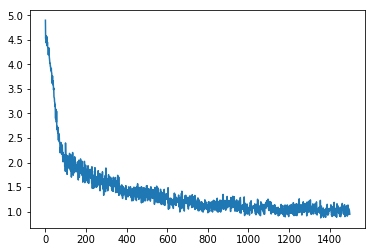

In [30]:
plt.plot([i for i in range(len(J))], J)

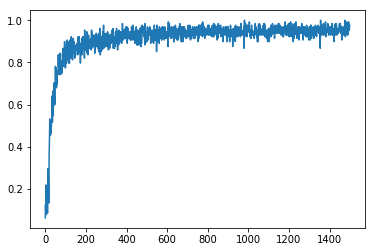

In [31]:
plt.plot([i for i in range(len(A))], A)

## 2.5 Testing

### 2.5.1 Accuracy

In [39]:
hparams =  {}
hparams["hparams_conv"] = {"pad": 0, "stride": 1}
hparams["hparams_pool"] = {"f": 2, "stride": 2}

In [40]:
#for training set
y_train_pred, _ = forward_prop(x_train, params, hparams)
train_loss, train_accuracy = calculate_loss_accuracy(y_train, y_train_pred, params, lmbda = 0.5)
print('Accuracy of Train Set = {}'.format(round(train_accuracy*100,2)))

#for valid set
y_val_pred, _ = forward_prop(x_val,params, hparams)
val_loss, val_accuracy = calculate_loss_accuracy(y_val, y_val_pred, params, lmbda = 0.5)
print('Accuracy of Valid Set = {}'.format(round(val_accuracy*100,2)))

#for test set
y_test_pred, _ = forward_prop(x_test, params, hparams)
test_loss, test_accuracy = calculate_loss_accuracy(y_test, y_test_pred, params, lmbda =0.5)
print('Accuracy of Test  Set = {}'.format(round(test_accuracy*100,2)))

Accuracy of Train Set = 95.33
Accuracy of Valid Set = 94.94
Accuracy of Test  Set = 95.6


### 2.5.2 Example predictions

Test Image


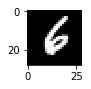

Predicted Label = 6


Test Image


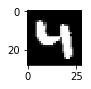

Predicted Label = 4


Test Image


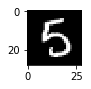

Predicted Label = 5


Test Image


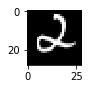

Predicted Label = 2


Test Image


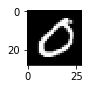

Predicted Label = 0


Test Image


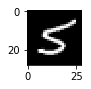

Predicted Label = 5


Test Image


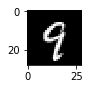

Predicted Label = 9


Test Image


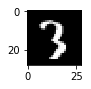

Predicted Label = 3


Test Image


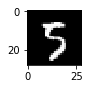

Predicted Label = 5


Test Image


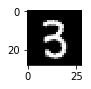

Predicted Label = 3




In [43]:
idx = np.random.randint(0, x_test.shape[0], 10)

x = x_test[:, 2:-2, 2:-2,:].reshape(x_test.shape[0],28,28)

for i in idx:
    print("Test Image")
    plt.figure(figsize = (1,1))
    plt.imshow(x[i], cmap='gray')
    plt.show()
    print("Predicted Label = {}".format(np.argmax(y_test_pred[i])))
    print("\n")